## Stage 4. Training Models

### 1. Necessary Imports and Setup

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, r2_score, ConfusionMatrixDisplay, classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils import resample
from scipy.stats import randint
import graphviz

from imblearn.over_sampling import RandomOverSampler, SMOTE

sb.set_theme()

randomStateNumber = 1

In [2]:
# Read data
df = pd.read_csv('data/processed_data_downsampled.csv')

print(df.shape)

# Set up all features, categorical and numerical
label = "DepDel15"

feature_set = pd.DataFrame(df.drop(labels=[label], axis=1))
label_set = pd.DataFrame(df[label])


(290258, 391)


### 2. Preparing Train/Test Splits

In [3]:
X_train, X_test, y_train, y_test = train_test_split(feature_set, label_set, test_size=0.2, random_state=randomStateNumber)

### 3. Multi-Variate Decision Tree Classifier

0.6044408461379452


<Axes: >

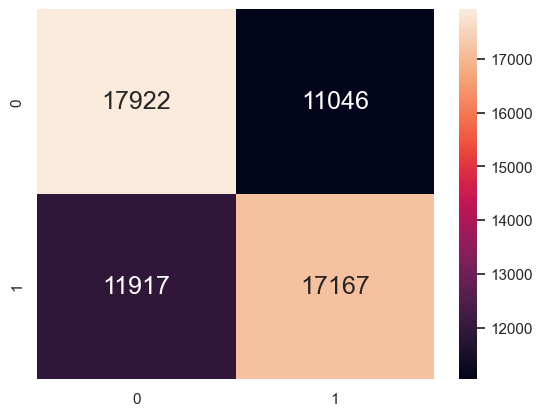

In [34]:
# Decision Tree Classifier
model_dt = DecisionTreeClassifier(random_state=randomStateNumber)
model_dt.fit(X_train, y_train)
model_dt_y_pred = model_dt.predict(X_test)
print("X train: ", model_dt.score(X_train, y_train))
print("Y train: ", model_dt.score(X_test, y_test))

model_dt_accuracy = accuracy_score(y_test, model_dt_y_pred)
print(model_dt_accuracy)

sb.heatmap(confusion_matrix(y_test, model_dt_y_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [35]:
# f = plt.figure(figsize=(24,24))

# plot_tree(model_dt, filled=True, rounded=True, 
#           feature_names=X_train.columns, 
#           class_names=["No","Yes"])
     

### 4. Random Forest Classifier

In [36]:
model_rf = RandomForestClassifier(random_state=randomStateNumber)
model_rf.fit(X_train, y_train.values.ravel())
model_rf_y_pred = model_rf.predict(X_test)
print("X train: ", model_rf_y_pred.score(X_train, y_train))
print("Y train: ", model_rf_y_pred.score(X_test, y_test))

model_rf_accuracy = accuracy_score(y_test, model_rf_y_pred)
print(model_rf_accuracy)

sb.heatmap(confusion_matrix(y_test, model_rf_y_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

0.6035623234341625


In [ ]:
#'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 120

X train:  0.6389972696657279
Y train:  0.6071453179907669
0.6071453179907669


<Axes: >

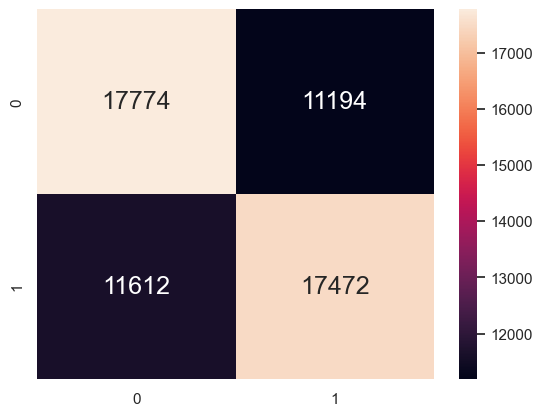

In [14]:
# model_rf = RandomForestClassifier(n_estimators=10, random_state=randomStateNumber, max_depth=100)
# model_rf.fit(X_train, y_train.values.ravel())
# model_rf_y_pred = model_rf.predict(X_test)
# model_rf.score(X_test, y_test)

# model_rf_accuracy = accuracy_score(y_test, model_rf_y_pred)
# print(model_rf_accuracy)
model_rf = RandomForestClassifier(random_state=randomStateNumber, n_estimators=120, min_samples_leaf=4, min_samples_split=2)
model_rf.fit(X_train, y_train.values.ravel())
model_rf_y_pred = model_rf.predict(X_test)
print("X train: ", model_rf.score(X_train, y_train))
print("Y train: ", model_rf.score(X_test, y_test))

model_rf_accuracy = accuracy_score(y_test, model_rf_y_pred)
print(model_rf_accuracy)

sb.heatmap(confusion_matrix(y_test, model_rf_y_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [38]:
# 5-Fold Cross validation
print(np.mean(cross_val_score(model_rf, X_train, y_train.values.ravel(), cv=5)))

0.6038561014727936


In [12]:
feature_importances = model_rf.feature_importances_

# Sort feature importances in descending order
top_indices = np.argsort(feature_importances)[::-1][:20]
least_relevant = np.argsort(feature_importances)[:20]

print(X_train.columns[least_relevant])

top_importances = feature_importances[top_indices]
top_features = X_train.columns[top_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(20), top_importances, align='center')
plt.xticks(range(20), top_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

NameError: name 'model_rf' is not defined

### 6. Tuning Hyper Parameters

In [7]:
param_dist = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Create model instance
rf_model = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train.values.ravel())

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 38}


In [11]:
# Define hyperparameters grid
param_grid = {
    'n_estimators': [100,120],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Create model instance
rf_model = RandomForestClassifier(random_state=randomStateNumber)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train.values.ravel())

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 120}
